In [1]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [2]:
!pip install pettingzoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 14.3 MB/s eta 0:00:00


In [3]:
!pip install 'shimmy>=2.0'

In [4]:
!pip install modin[ray]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00


In [5]:
!pip install supersuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 22.8 MB/s eta 0:00:00


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import time
import math

In [15]:
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import Dict
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, SAC
from gym.wrappers import FlattenObservation
from typing import Tuple, Dict, Optional, Any
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.utils import get_linear_fn
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [12]:
def optimal_linear_kyle(sigma_u, mean_v, sigma_v):
    beta = math.sqrt(sigma_u ** 2 / sigma_v ** 2)  # Insider's coefficient
    lambda_ = 0.5 * math.sqrt(sigma_v ** 2 / (sigma_u ** 2))  # MM's coefficient
    return beta, lambda_

def optimal_insider_x(v, sigma_u, mean_v, sigma_v):
    beta, _ = optimal_linear_kyle(sigma_u, mean_v, sigma_v)

    return beta * (v - mean_v)

def set_linear_price(y, sigma_v, sigma_u, mean_v):
    beta, lambda_ = optimal_linear_kyle(sigma_u, mean_v, sigma_v)
    return mean_v + lambda_ * y

In [ ]:
class KyleModelEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnv, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        self.observation_space = spaces.Dict({
            'v': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'p': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_v': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_u': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })

        self.reset()

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)

        self.v = np.random.normal(self.p0, self.sigma_v)  # True asset value
        self.p = self.p0
        self.t = 0

        obs = self._get_insider_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_insider_obs(self):
        return {
            'v': np.array([self.v], dtype=np.float32),
            'p': np.array([self.p], dtype=np.float32),
            'sigma_v': np.array([self.sigma_v**2], dtype=np.float32),
            'sigma_u': np.array([self.sigma_u**2], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        scaled_action = action * 10
        self.actual_actions.append(scaled_action[0])

        x = scaled_action[0]
        u = np.random.normal(0, self.sigma_u)
        y = x + u
        beta_kyle, lambda_kyle = optimal_linear_kyle(self.sigma_u, self.p0, self.sigma_v)
        p_new = self.p + lambda_kyle * y

        insider_profit = (self.v - p_new) * x

        # Update state
        self.p = p_new
        self.t += 1

        terminated = (self.t >= self.T)  # natural end
        truncated = False  # No time/truncation logic here

        obs = self._get_insider_obs()
        info = {}

        return obs, insider_profit, terminated, truncated, info



# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_insider = KyleModelEnv()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=dict(pi=[64], vf=[64])  # Separate networks
)

model_insider = PPO(
    "MultiInputPolicy",
    env_insider,
    verbose = 1,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs

)

model_insider.learn(total_timesteps=45_000)

# Test trained agent
obs = env_insider.reset()

Testing Kyle model with Gym interface
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -27      |
| time/              |          |
|    fps             | 1355     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | -18.3      |
| time/                   |            |
|    fps                  | 955        |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.10985115 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.295      |
|    entropy_loss         | -1.28      |
|    explained_variance   | -0.000279  |
|    learning_rate        | 0.001      |
|   

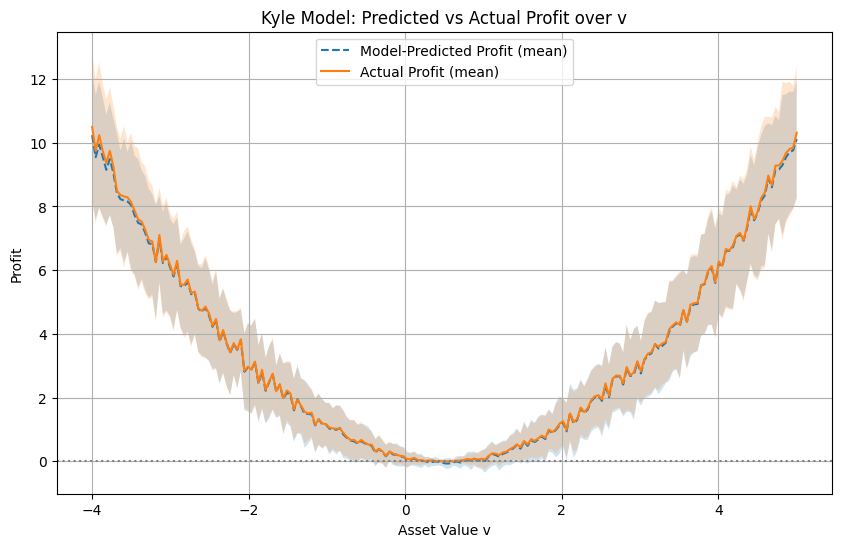

In [ ]:
def evaluate_profits(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs['v'][0] = v
        env.v = v

        for j in range(num_trials):

            #  and draw fixed v and u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


            action, _ = model.predict(obs)
            # 1. Scale PPO's normalized action to market order size

            x = action[0] * 10  # scale to actual action

            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u

            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit


    return predicted_profits, actual_profits


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -4
end_point = 5
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




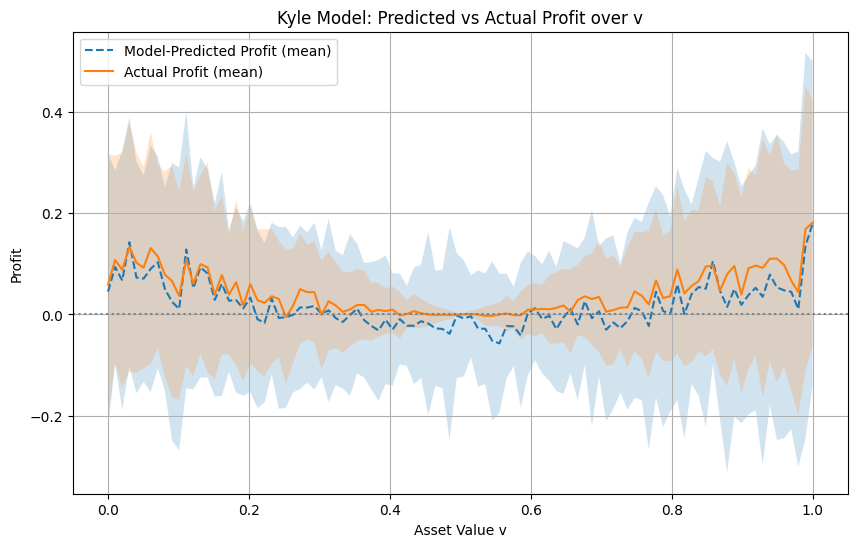

In [ ]:
start_point = 0
end_point = 1
num_points = 100
num_trials = 50
predicted, actual = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points = 100)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)


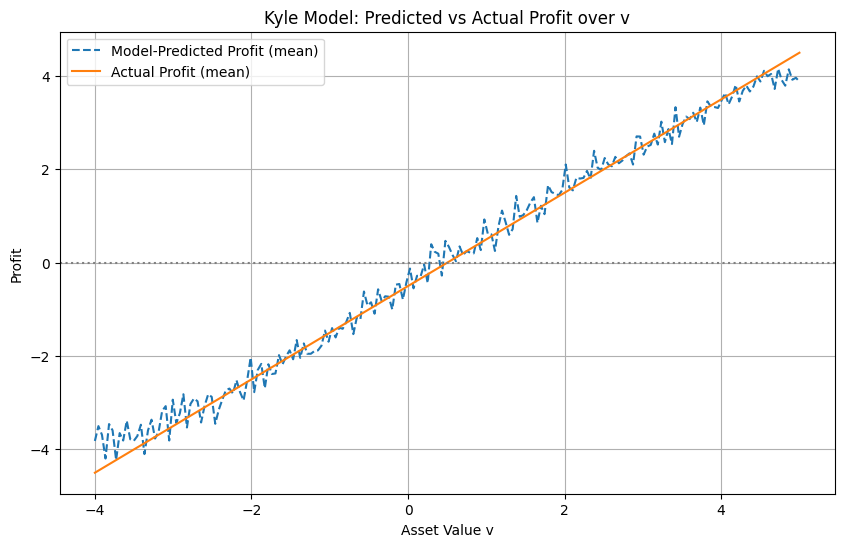

In [ ]:
def evaluate_model_insider(env, start_point, end_point, model, num_points = 100):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_points))
    actual_profits = np.zeros((num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs['v'][0] = v
        env.v = v
        beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


        action, _ = model.predict(obs)

        x = action[0] * 10  # scale to actual action

        actual_x = optimal_insider_x(v, env.sigma_u, env.p0, env.sigma_v)

        predicted_profits[i] = x
        actual_profits[i] = actual_x

    return predicted_profits, actual_profits


def plot_model(predicted_profits, actual_profits, values, predicted_mean,
                                                                 actual_mean):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -4
end_point = 5
num_points = 200
num_trials = 100
predicted, actual = evaluate_model_insider(env_insider, start_point, end_point, model_insider, num_points)
values = np.linspace(start_point, end_point, num_points)



plot_model(predicted, actual, values, predicted, actual)




In [ ]:

class KyleModelEnvMM(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnvMM, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        self.beta_kyle, _ = optimal_linear_kyle(self.sigma_u, self.p0, self.sigma_v)

        # Define action space (Market Maker's price guess)
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Observation space for the market maker
        self.observation_space = spaces.Dict({
            'y': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'p0': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_v': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_u': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })

    def reset(self, *, seed=None, options=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)

        # True asset value is drawn from N(p0, sigma_v^2)
        self.v = np.random.normal(self.p0, self.sigma_v)

        # Initialize state variables
        self.p = self.p0
        self.t = 0

        # Generate initial observation
        self.x = self.beta_kyle * (self.v - self.p0)
        u = np.random.normal(0, self.sigma_u)
        self.y = self.x + u

        obs = self._get_mm_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_mm_obs(self) -> Dict[str, np.ndarray]:
        return {
            'y': np.array([self.y], dtype=np.float32),
            'p0': np.array([self.p], dtype=np.float32),
            'sigma_v': np.array([self.sigma_v**2], dtype=np.float32),
            'sigma_u': np.array([self.sigma_u**2], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step of the environment"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        # Scale PPO's normalized action to market price guess
        scaled_action = action[0] * 10
        self.actual_actions.append(scaled_action)

        # Market maker's loss function (negative MSE against true value)
        mm_loss = -((scaled_action - self.v) ** 2)

        # Update timestep
        self.t += 1

        terminated = (self.t >= self.T)  # natural termination
        truncated = False  # no time truncation here

        obs = self._get_mm_obs()
        info = {}

        return obs, mm_loss, terminated, truncated, info







# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_mm = KyleModelEnvMM()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=[64,64]
)

model_mm = PPO(
    "MultiInputPolicy",
    env_mm,
    verbose = 1,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs,
    ent_coef = 0.03

)

model_mm.learn(total_timesteps=75_000)
model_mm.save("ppo_mm")

# Test trained agent
obs = env_mm.reset()

Testing Kyle model with Gym interface
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    fps             | 1116     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -47         |
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.086519174 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.297       |
|    entropy_loss         | -1.29       |
|    explained_variance   | -0.000592   |
|    learning_rate        | 0.

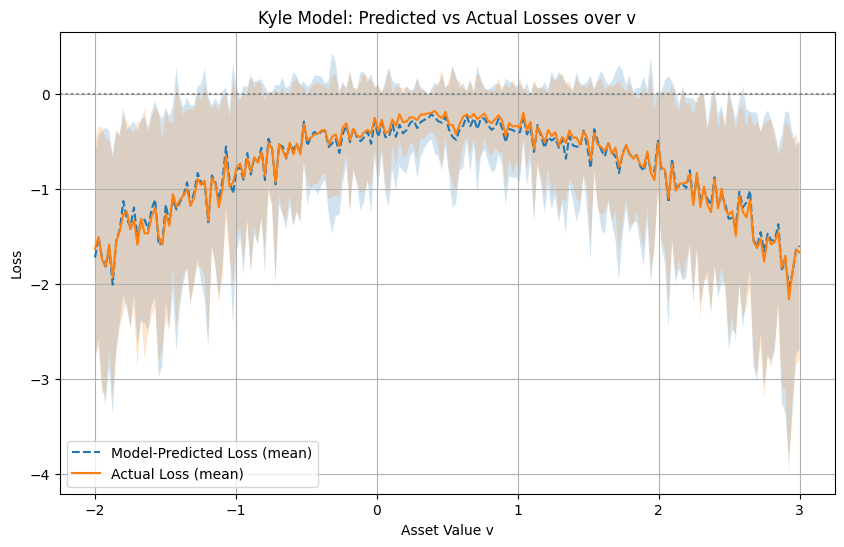

In [ ]:
def evaluate_losses(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_losses = np.zeros((num_trials, num_points))
    actual_losses = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        env.v = v

        for j in range(num_trials):

            #  and sample u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)
            x = beta_kyle * (v - env.p0)


            y = x + u
            obs['y'] = np.array([y], dtype=np.float32)

            # Scale PPO's normalized action to market order size
            action, _ = model.predict(obs)
            scaled_action = action[0] * 10  # scale to actual action




            kyle_price = env.p0 + lambda_kyle * y

            predicted_loss = - ((scaled_action - v) ** 2)
            actual_loss = - ((v - kyle_price) ** 2)

            predicted_losses[j][i] = predicted_loss
            actual_losses[j][i] = actual_loss
            if actual_loss > 20:
                print(f"beta kyle : {beta_kyle}")
                print(f"lambda kyle : {lambda_kyle}")
                print(f"predicted loss : {predicted_loss}")
                print(f"actual loss : {actual_loss}")
                print(f"scaled action : {scaled_action}")
                print(f"kyle price : {kyle_price}")
                print(f"x : {x}")
                print(f"y : {y}")
                print(f"u : {u}")
                print(f"v : {v}")


    return predicted_losses, actual_losses


def plot_losses(predicted_losses, actual_losses, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Loss (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Loss (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Loss")
    plt.title("Kyle Model: Predicted vs Actual Losses over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_losses(env_mm, start_point, end_point, model_mm, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_losses(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




In [ ]:
def evaluate_model_mm(env, start_point, end_point, model, num_points = 100):
    values = np.linspace(start_point, end_point, num_points)
    predicted_losses = np.zeros((num_points))
    actual_losses = np.zeros((num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        env.v = v

        actual_y = set_linear_price(env.sigma_u, env.p0, env.sigma_v)

        action, _ = model.predict(obs)

        y = action[0] * 10  # scale to actual action

        predicted_losses[i] = y
        actual_losses[i] = actual_y


    return predicted_losses, actual_losses


def plot_model_mm(predicted_losses, actual_losses, values, predicted_mean, actual_mean):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Loss (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Loss (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Loss")
    plt.title("Kyle Model: Predicted vs Actual Losses over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_model_mm(env_mm, start_point, end_point, model_mm, num_points)
values = np.linspace(start_point, end_point, num_points)

plot_model_mm(predicted, actual, values, predicted, actual)




NameError: name 'env_mm' is not defined

In [ ]:
from pettingzoo.utils import AECEnv, agent_selector, aec_to_parallel
from ray.rllib.env import PettingZooEnv
from ray import tune
import ray
import numpy as np
from gymnasium import spaces
from pettingzoo.utils import ParallelEnv
from ray.rllib.env import PettingZooEnv
from ray import tune
import ray

2025-08-16 14:43:07,871	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.


In [ ]:
import functools
import glob
import os
import time
import gymnasium as gym

from ray.rllib.env.multi_agent_env import MultiAgentEnv
import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy, MlpPolicy

In [253]:
import numpy as np
import functools
from pettingzoo import AECEnv
from gymnasium import spaces
from pettingzoo.utils.agent_selector import AgentSelector


class KyleOnePeriodAEC(AECEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodAEC",
    }

    def __init__(self, sigma_v=2.0, sigma_u=1.0, p0=0.5, gamma=0.9, T=1):
        super().__init__()
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.timestep = 0
        self.gamma = gamma
        self.T = T

        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]
        self.render_mode = None
        self.rewards = {a: 0 for a in self.agents}
        self.agent_selector = AgentSelector(self.agents)

        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}
        self._cumulative_rewards = {a: 0 for a in self.agents}
        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}
        self.infos = {a: {} for a in self.agents}
        self.timestep = 0

        # Sample true value
        self.v = np.random.normal(self.p0, self.sigma_v)
        self.u = np.random.normal(0, self.sigma_u)
        self.p = 0
        self.y = 0

        # Set first agent
        self.agent_selector.reinit(self.agents)
        self.agent_selection = self.agent_selector.next()


    def observe_insider(self):
        return np.array([self.v, self.p0, self.sigma_v**2, self.sigma_u**2], dtype=np.float32)

    def observe_market_maker(self):
        return np.array([self.p0, self.sigma_v**2, self.sigma_u**2, self.y], dtype=np.float32)

    def observe(self, agent):
        if agent == "insider":
            return self.observe_insider()
        elif agent == "market_maker":
            return self.observe_market_maker()

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]

    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection

        # Store the action
        if agent == "insider":
            self.insider_action = action[0] * 5
            self.y = self.insider_action + self.u
        elif agent == "market_maker":
            self.market_maker_action = action[0] * 5

        # If both agents have taken their turn, calculate outcomes
        if self.agent_selector.is_last():
            # Calculate order flow and profits

            insider_profit = (self.v - self.market_maker_action) * self.insider_action
            market_maker_loss = - (self.market_maker_action - self.v)  ** 2

            # Assign rewards
            self.rewards = {
                "insider": insider_profit,
                "market_maker": market_maker_loss
            }

            # Update timestep
            self.timestep += 1
            if self.timestep >= self.T:
                self.terminations = {a: True for a in self.agents}

            # Update cumulative rewards
            for a in self.agents:
                self._cumulative_rewards[a] += self.rewards[a]

        # Get next agent
        self.agent_selection = self.agent_selector.next()

    def render(self):
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        if hasattr(self, 'rewards'):
            print(f"Agents' rewards: {self.rewards}")

    def close(self):
        pass

In [254]:
import numpy as np

# make environment
env = KyleOnePeriodAEC(T=1)  # play 3 periods to test multiple steps

# reset
observations = env.reset()
print("Initial observations:", observations)
done = True

# Run until environment terminates
while done and env.agents:  # stops automatically when all agents are done
    # Stop after one full round of all agents
    if env.agent_selector.is_last():
        done = False
        print("Da")
    agent = env.agent_selection

    action = np.random.uniform(-1, 1, size=1) if not env.terminations[agent] else None


    env.step(action)
    obs = env.observe(agent)
    print(f"\nAgent: {agent}, Obs: {obs}, Action: {action}")
    print(f"Rewards: {env.rewards}")
    print(f"Terminations: {env.terminations}")
    print(f"Truncations: {env.truncations}")
    env.render()



Initial observations: None

Agent: insider, Obs: [-0.7259359  0.5        4.         1.       ], Action: [-0.56808224]
Rewards: {'insider': 0, 'market_maker': 0}
Terminations: {'insider': False, 'market_maker': False}
Truncations: {'insider': False, 'market_maker': False}
Step: 0
True value v: -0.73
Order flow y: -3.31
Agents' rewards: {'insider': 0, 'market_maker': 0}
Da

Agent: market_maker, Obs: [ 0.5        4.         1.        -3.3115253], Action: [-0.28629069]
Rewards: {'insider': np.float64(-2.003960038601349), 'market_maker': np.float64(-0.49775505420423)}
Terminations: {'insider': True, 'market_maker': True}
Truncations: {'insider': False, 'market_maker': False}
Step: 1
True value v: -0.73
Order flow y: -3.31
Agents' rewards: {'insider': np.float64(-2.003960038601349), 'market_maker': np.float64(-0.49775505420423)}


In [255]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- create env ---
env = KyleOnePeriodAEC()

# Policy network per agent
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, act_dim)
        )
        self.log_std = nn.Parameter(torch.full((act_dim,), -1.0))

    def forward(self, x):
        mu = torch.tanh(self.fc(x))
        std = torch.exp(self.log_std)
        return mu, std

policies = {
    "insider": Policy(obs_dim=4, act_dim=1),
    "market_maker": Policy(obs_dim=4, act_dim=1)
}
optimizers = {a: optim.Adam(policies[a].parameters(), lr=1e-4) for a in policies}



In [277]:
num_episodes = 20000
gamma = 0.9
rewards_insider = np.zeros(num_episodes)

In [278]:
for episode in range(num_episodes):
    # Reset environment
    env.reset()

    done = False
    log_probs = {a: [] for a in env.possible_agents}
    rewards = {a: [] for a in env.possible_agents}

    # Rollout
    while not done and env.agents:  # while there are still live agents

        if env.agent_selector.is_last():
            done = True

        if episode % 1000 == 0:
            print(f"Episode: {episode}")

        agent = env.agent_selection  # whose turn is it?

        obs = env.observe(agent)
        obs_tensor = torch.tensor(obs, dtype=torch.float32)

        mu, std = policies[agent](obs_tensor)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()

        env.step(action.detach().numpy())  # step only this agent!

        # record log_prob for update
        log_probs[agent].append(log_prob)

        # rewards are updated after *all* agents in a cycle have acted
    for a in env.agents:
        rewards[a].append(env.rewards[a])

    rewards_insider[episode] = env.rewards["insider"]

    # --- Policy Gradient Update (REINFORCE) ---
    for a in env.possible_agents:
        if len(rewards[a]) == 0:
            continue
        total_reward = sum(rewards[a])  # one-period game, so just sum
        loss = -torch.stack(log_probs[a]).sum() * total_reward
        optimizers[a].zero_grad()
        loss.backward()
        optimizers[a].step()


Episode: 0
Episode: 0
Episode: 1000
Episode: 1000
Episode: 2000
Episode: 2000
Episode: 3000
Episode: 3000
Episode: 4000
Episode: 4000
Episode: 5000
Episode: 5000
Episode: 6000
Episode: 6000
Episode: 7000
Episode: 7000
Episode: 8000
Episode: 8000
Episode: 9000
Episode: 9000
Episode: 10000
Episode: 10000
Episode: 11000
Episode: 11000
Episode: 12000
Episode: 12000
Episode: 13000
Episode: 13000
Episode: 14000
Episode: 14000
Episode: 15000
Episode: 15000
Episode: 16000
Episode: 16000
Episode: 17000
Episode: 17000
Episode: 18000
Episode: 18000
Episode: 19000
Episode: 19000


In [243]:
batch_size = 16 # number of episodes per update
num_batches = 5000 # number of updates

for batch in range(num_batches):
    batch_log_probs = {a: [] for a in env.possible_agents}
    batch_rewards = {a: [] for a in env.possible_agents}

    if batch % 500 == 0:
        print(f"Batch: {batch}")

    for episode in range(batch_size):
        env.reset()
        done = False
        log_probs = {a: [] for a in env.possible_agents}
        rewards = {a: [] for a in env.possible_agents}

        while not done and env.agents:
            if env.agent_selector.is_last():
                done = True

            agent = env.agent_selection
            obs = env.observe(agent)
            obs_tensor = torch.tensor(obs, dtype=torch.float32)

            mu, std = policies[agent](obs_tensor)
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum()

            env.step(action.detach().numpy())

            log_probs[agent].append(log_prob)

        # store total reward per episode
        for a in env.possible_agents:
            rewards[a].append(env.rewards[a])

        for a in env.possible_agents:
            batch_log_probs[a].append(torch.stack(log_probs[a]).sum())
            batch_rewards[a].append(sum(rewards[a]))

    for a in env.possible_agents:
        rewards_tensor = torch.tensor(batch_rewards[a], dtype=torch.float32)
        rewards_norm = (rewards_tensor - rewards_tensor.mean()) / (rewards_tensor.std() + 1e-8)

        # Compute policy gradient loss
        loss = -(torch.stack(batch_log_probs[a]) * rewards_norm).mean()  # mean over batch
        optimizers[a].zero_grad()
        loss.backward()
        optimizers[a].step()



Batch: 0
Batch: 500
Batch: 1000
Batch: 1500
Batch: 2000
Batch: 2500
Batch: 3000
Batch: 3500
Batch: 4000
Batch: 4500


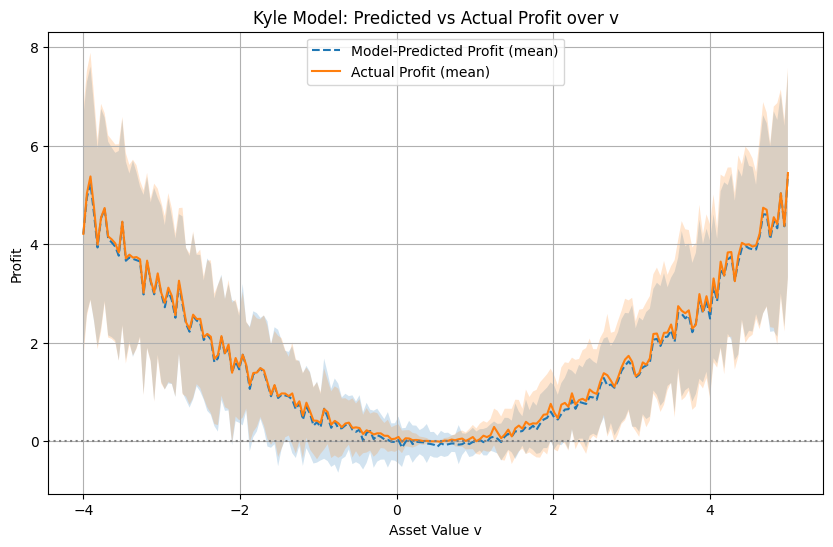

In [279]:
def evaluate_profits_insider(env, start_point, end_point, policies, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        env.reset()
        env.v = v
        obs = env.observe("insider")
        obs[0] = v
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        mu, std = policies["insider"](obs_tensor)
        dist = torch.distributions.Normal(mu, std)
        """
        print(f"obs: {obs}")
        print(f"v value is {env.v}")
        print(f"mu value is {mu}")
        print(f"std value is {std}")
        time.sleep(5)
        """
        for j in range(num_trials):

            #  and draw fixed v and u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


            action = dist.sample()
            # 1. Scale PPO's normalized action to market order size

            x = action[0] * 5  # scale to actual action

            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u

            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit


    return predicted_profits, actual_profits


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -4
end_point = 5
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits_insider(env, start_point, end_point, policies, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




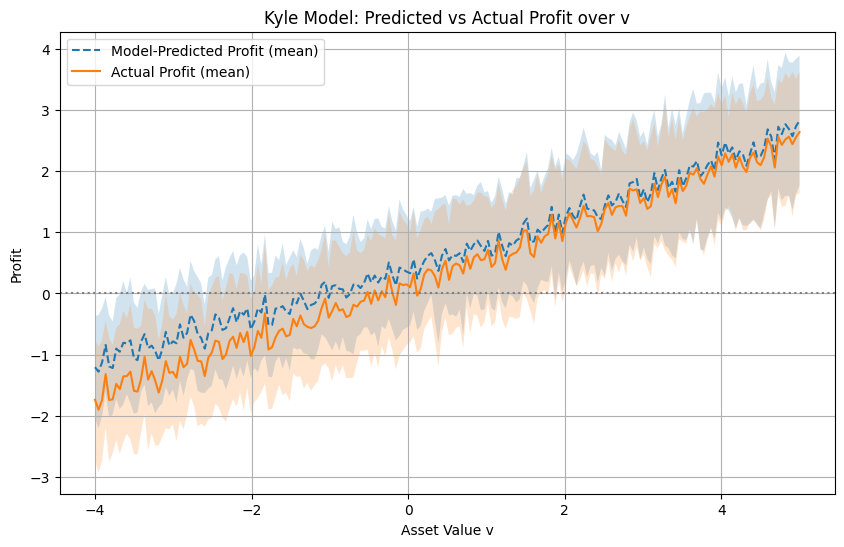

In [280]:
def evaluate_model_mm(env, start_point, end_point, policies, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_losses = np.zeros((num_trials, num_points))
    actual_losses = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        env.reset()
        env.v = v
        obs = env.observe("insider")
        obs[0] = v
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        mu, std = policies["insider"](obs_tensor)
        dist = torch.distributions.Normal(mu, std)

        obs_mm = env.observe("market_maker")




        """
        print(f"obs: {obs}")
        print(f"v value is {env.v}")
        print(f"mu value is {mu}")
        print(f"std value is {std}")
        """
        for j in range(num_trials):

            #  and draw fixed v and u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


            action = dist.sample()
            # 1. Scale PPO's normalized action to market order size

            x = action[0] * 5  # scale to actual action

            y = x + u


            obs_mm[3] = y
            obs_tensor_mm = torch.tensor(obs_mm, dtype=torch.float32)
            mu_mm, std_mm = policies["market_maker"](obs_tensor_mm)
            dist_mm = torch.distributions.Normal(mu_mm, std_mm)

            action_mm = dist_mm.sample()

            predicted_price = action_mm[0] * 5
            actual_price = env.p0 + lambda_kyle * y

            predicted_loss = -(v - predicted_price) ** 2
            actual_loss = -(v - actual_price) ** 2
            """
            print(f"obs_mm : {obs_mm}")
            print(f"predicted_loss is {predicted_loss}")
            """
            # Predicted profit using known v and expected price impact

            predicted_losses[j][i] = predicted_price
            actual_losses[j][i] = actual_price


    return predicted_losses, actual_losses


def plot_model_mm(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)



    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -4
end_point = 5
num_points = 200
num_trials = 100
predicted, actual = evaluate_model_mm(env, start_point, end_point, policies, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_model_mm(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




<class 'numpy.ndarray'>


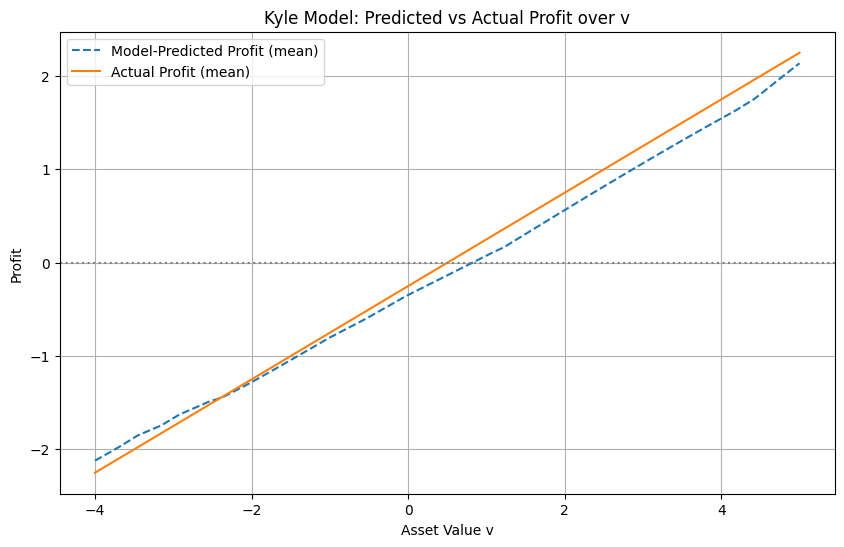

In [285]:
def evaluate_model_insider(env, start_point, end_point, policies, num_points = 100):
    values = np.linspace(start_point, end_point, num_points)
    predicted_x = np.zeros((num_points))
    actual_x = np.zeros((num_points))
    print(type(actual_x))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        env.reset()
        env.v = v
        obs = env.observe("insider")
        obs[0] = v
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        mu, std = policies["insider"](obs_tensor)


        beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)

        x = mu * 5  # scale to actual action

        act_x = optimal_insider_x(v, env.sigma_u, env.p0, env.sigma_v)

        predicted_x[i] = x
        actual_x[i] = act_x

    return predicted_x, actual_x


def plot_model(predicted_profits, actual_profits, values, predicted_mean,
                                                                 actual_mean):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -4
end_point = 5
num_points = 200
num_trials = 100
predicted, actual = evaluate_model_insider(env, start_point, end_point, policies, num_points)
values = np.linspace(start_point, end_point, num_points)



plot_model(predicted, actual, values, predicted, actual)




In [ ]:
for episode in range(1):
    # Reset environment
    env.reset()

    done = False
    log_probs = {a: [] for a in env.possible_agents}
    rewards = {a: [] for a in env.possible_agents}

    # Rollout
    while not done and env.agents:  # while there are still live agents

        if env.agent_selector.is_last():
            done = True

        if episode % 1000 == 0:
            print(f"Episode: {episode}")

        agent = env.agent_selection  # whose turn is it?

        obs = env.observe(agent)
        obs_tensor = torch.tensor(obs, dtype=torch.float32)

        mu, std = policies[agent](obs_tensor)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()

        env.step(action.detach().numpy())  # step only this agent!

        # record log_prob for update
        log_probs[agent].append(log_prob)
        if episode % 10000 == 0:
            print(f"Agent: {agent}, Obs: {obs}, Action: {action}")
            print(f"Rewards: {env.rewards}")
            print(f"Terminations: {env.terminations}")
            print(f"Truncations: {env.truncations}")
            print(f"Mean: {mu}, Std: {std}")
            print(f"Log probs: {log_probs}")

        # rewards are updated after *all* agents in a cycle have acted
    for a in env.agents:
        rewards[a].append(env.rewards[a])
    print(f"rewards: {rewards}")
    print(f"y: {env.y}")

    # --- Policy Gradient Update (REINFORCE) ---
    for a in env.possible_agents:
        if len(rewards[a]) == 0:
            continue
        total_reward = sum(rewards[a])  # one-period game, so just sum
        print(f"total_reward: {total_reward}")
        loss = -torch.stack(log_probs[a]).sum() * total_reward
        print(f"loss: {loss}")
        optimizers[a].zero_grad()
        loss.backward()
        optimizers[a].step()

Episode: 0
Agent: insider, Obs: [1.1927187 0.5       1.        1.       ], Action: tensor([0.1082])
Rewards: {'insider': 0, 'market_maker': 0}
Terminations: {'insider': False, 'market_maker': False}
Truncations: {'insider': False, 'market_maker': False}
Mean: tensor([0.1135], grad_fn=<TanhBackward0>), Std: tensor([0.0244], grad_fn=<ExpBackward0>)
Log probs: {'insider': [tensor(2.7706, grad_fn=<SumBackward0>)], 'market_maker': []}
Episode: 0
Agent: market_maker, Obs: [ 0.5         1.          1.         -0.04649645], Action: tensor([0.0961])
Rewards: {'insider': np.float32(0.3850511), 'market_maker': np.float32(-0.5070374)}
Terminations: {'insider': True, 'market_maker': True}
Truncations: {'insider': False, 'market_maker': False}
Mean: tensor([0.1265], grad_fn=<TanhBackward0>), Std: tensor([0.0175], grad_fn=<ExpBackward0>)
Log probs: {'insider': [tensor(2.7706, grad_fn=<SumBackward0>)], 'market_maker': [tensor(1.6204, grad_fn=<SumBackward0>)]}
rewards: {'insider': [np.float32(0.3850511

In [ ]:
env.rewards

{'insider': np.float32(-26.686844), 'market_maker': np.float32(-2.6051486)}

In [ ]:
from __future__ import annotations
import glob
import os
import time

import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy, MlpPolicy


def train_multi_agent(env_fn, steps: int = 10_000, loops: int = 50, seed: int | None = 0, **env_kwargs):
    env = env_fn(**env_kwargs)
    env = ss.black_death_v3(env)  # Handle agent death
    env.reset(seed=seed)

    print(f"Starting training on {env.metadata['name']} with {len(env.possible_agents)} agents.")

    env_vec = ss.pettingzoo_env_to_vec_env_v1(env)
    env_vec = ss.concat_vec_envs_v1(env_vec, 8, num_cpus=0, base_class="stable_baselines3")

    # Create a PPO model for each agent
    models = {}
    for agent in env.possible_agents:
        models[agent] = PPO(MlpPolicy, env_vec, verbose=3, batch_size=256)

    # Train models in interchangeable loops
    for loop in range(loops):
        print(f"=== Training loop {loop+1}/{loops} ===")
        for agent in env.possible_agents:
            print(f"Training model for {agent}")
            models[agent].learn(total_timesteps=steps)

    # Save all models after training
    for agent, model in models.items():
        model_path = f"{env.metadata['name']}_{agent}_{time.strftime('%Y%m%d-%H%M%S')}"
        model.save(model_path)
        print(f"Saved model for {agent} -> {model_path}")

    env.close()
    return models




env_fn = KyleOnePeriodAEC
env_kwargs = dict(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma = 0.9, T = 1)

# Train a separate model for each agent
models = train_multi_agent(env_fn, steps=50_000, seed=0, **env_kwargs)

Starting training on KyleOnePeriodParallel with 2 agents.
Using cpu device
Using cpu device
=== Training loop 1/50 ===
Training model for insider
------------------------------
| time/              |       |
|    fps             | 7319  |
|    iterations      | 1     |
|    time_elapsed    | 4     |
|    total_timesteps | 32768 |
------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 4011       |
|    iterations           | 2          |
|    time_elapsed         | 16         |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.04362922 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.3       |
|    explained_variance   | 0.00106    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.32e+03   |
|    n_updates            | 10         |
|    policy_gradient_l

In [ ]:
from stable_baselines3 import PPO

insider_model = PPO.load("KyleOnePeriodParallel_insider_20250814-015141")
market_maker_model = PPO.load("KyleOnePeriodParallel_market_maker_20250814-001537")

models = {
    "insider": insider_model,
    "market_maker": market_maker_model
}


In [ ]:
env = KyleOnePeriodAEC(sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma=0.9, T=1)
observations, infos = env.reset()

In [ ]:
actions = {}
beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)

print(f"v value is {env.v}")
print(f"x_optimal {beta_kyle*(env.v-env.p0)}")


for agent, model in models.items():
    obs = observations[agent]
    action, _states = model.predict(obs, deterministic=True)  # or False if you want stochastic
    actions[agent] = action



    print(f"Agent: {agent}, Action: {action}")



v value is 1.1813457885867087
x_optimal 0.6813457885867087
Agent: insider, Action: [0.90708625]
Agent: market_maker, Action: [0.07668986]


Streaming output truncated to the last 5000 lines.
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36068832874298096
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3718290328979492
v value is 0.7638190954773871
Agent: market_maker, Action: 0.33802521228790283
v value is 0.7638190954773871
Agent: market_maker, Action: 0.38235533237457275
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36364632844924927
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3876854479312897
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3699757754802704
v value is 0.7638190954773871
Agent: market_maker, Action: 0.3655184805393219
v value is 0.7638190954773871
Agent: market_maker, Action: 0.37164291739463806
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36300525069236755
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36692655086517334
v value is 0.7638190954773871
Agent: market_maker, Action: 0.36268797516822815
v val

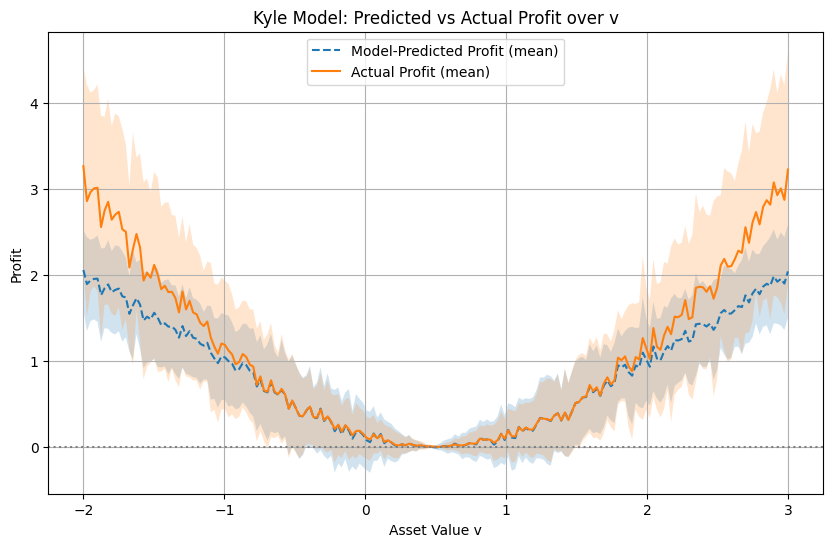

In [ ]:
def evaluate_profits(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))
    agent1 = "insider"


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs = observations[agent]
        obs[0] = v
        env.v = v

        for j in range(num_trials):

            #  and draw fixed v and u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


            action, _ = model.predict(obs)
            # 1. Scale PPO's normalized action to market order size
            action_unscaled = float(action[0])


            x = action_unscaled  # scale to actual action
            if v > -1 and v < 2:
                print(f"v value is {env.v}")
                print(f"Agent: {agent}, Action: {x}")
            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u

            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit


    return predicted_profits, actual_profits


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env, start_point, end_point, insider_model, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




In [ ]:
start_point = -1
end_point = 2
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env, start_point, end_point, insider_model, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)



In [ ]:
start_point = -0.5
end_point = 1.5
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env, start_point, end_point, insider_model, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)


In [ ]:
import numpy as np
import gymnasium as gym
from ray.rllib.env.multi_agent_env import MultiAgentEnv

class KyleOnePeriodRLlib(MultiAgentEnv):
    """Kyle's model environment adapted for RLlib's MultiAgentEnv API."""

    def __init__(self, config=None):
        super().__init__()

        # Extract parameters from config or use defaults
        config = config or {}
        self.sigma_v = config.get("sigma_v", 1.0)
        self.sigma_u = config.get("sigma_u", 1.0)
        self.p0 = config.get("p0", 0.5)
        self.gamma = config.get("gamma", 0.9)
        self.T = config.get("T", 1)

        self.timestep = 0

        # Define possible agents
        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]

        # Define observation and action spaces
        self.observation_spaces = {
            "insider": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }

        self.action_spaces = {
            "insider": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": gym.spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }

        # Initialize state variables
        self.v = 0
        self.u = 0
        self.p = 0
        self.y = 0

    def reset(self, *, seed=None, options=None):
        """Resets the environment and returns initial observations."""
        super().reset(seed=seed)

        self.timestep = 0
        self.agents = self.possible_agents[:]

        # Sample true value and noise
        self.v = self.np_random.normal(self.p0, self.sigma_v)
        self.u = self.np_random.normal(0, self.sigma_u)
        self.p = 0
        self.y = 0

        # Return observations for all agents
        observations = {
            "insider": self.observe_insider(),
            "market_maker": self.observe_market_maker(),
        }

        return observations, {}

    def step(self, action_dict):
        """Executes one environment step for all agents."""
        # Execute actions
        insider_action = action_dict["insider"][0]
        market_maker_action = action_dict["market_maker"][0]

        # Update environment state
        self.y = insider_action + self.u
        insider_profit = (self.v - market_maker_action) * insider_action
        market_maker_loss = -((market_maker_action - self.v) ** 2)

        # Calculate rewards
        rewards = {
            "insider": insider_profit,
            "market_maker": market_maker_loss,
        }

        # Update timestep and check termination
        self.timestep += 1
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}

        if self.timestep >= self.T:
            terminations = {a: True for a in self.agents}
            self.agents = []

        # Get new observations
        observations = {
            "insider": self.observe_insider(),
            "market_maker": self.observe_market_maker(),
        }

        # Dummy infos
        infos = {a: {} for a in self.agents}

        return observations, rewards, terminations, truncations, infos

    def observe_insider(self):
        return np.array([self.v, self.p0, self.sigma_v**2, self.sigma_u**2], dtype=np.float32)

    def observe_market_maker(self):
        return np.array([self.p0, self.sigma_v**2, self.sigma_u**2, self.y], dtype=np.float32)


    def get_observation_space(self, agent_id):
        return self.observation_spaces[agent_id]

    def render(self):
        """Renders the current state of the environment."""
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        if hasattr(self, "rewards"):
            print(f"Agents' rewards: {self.rewards}")

In [ ]:
class KyleOnePeriodAEC(ParallelEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodParallel",
    }

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma = 0.9, T = 1):
        super().__init__()
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.timestep = 0
        self.gamma = gamma
        self.T = T

        self.possible_agents = ["insider", "market_maker"]
        self.render_mode = None  # add this line

        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }




    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}

        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}

        self.infos = {a: {} for a in self.agents}
        self.timestep = 0

        # Sample true value
        self.v = np.random.normal(self.p0, self.sigma_v)
        self.u = np.random.normal(0, self.sigma_u)
        self.p = 0
        self.y = 0

        observations = {}
        observations["insider"] = self.observe_insider()
        observations["market_maker"] = self.observe_market_maker()

        # Get dummy infos. Necessary for proper parallel_to_aec conversion
        infos = {a: {} for a in self.agents}


        return observations, infos

    def observe(self, agent):
        if agent == "insider":
            return self.observe_insider()
        elif agent == "market_maker":
            return self.observe_market_maker()

    def observe_insider(self):
        return np.array([self.v, self.p0, self.sigma_v**2, self.sigma_u**2], dtype=np.float32)

    def observe_market_maker(self):
        return np.array([self.p0, self.sigma_v**2, self.sigma_u**2, self.y], dtype=np.float32)

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]


    def step(self, actions):
        # Default rewards
        rewards = {a: 0 for a in self.agents}

        # Only update actions for agents that actually have an action
        insider_action = actions["insider"][0] * 10
        market_maker_action = actions["market_maker"][0] * 10


        self.y = insider_action + self.u
        insider_profit = (self.v - market_maker_action) * insider_action
        market_maker_loss = -((market_maker_action - self.v) ** 2)

        if "insider" in self.agents:
            rewards["insider"] = insider_profit
        if "market_maker" in self.agents:
            rewards["market_maker"] = market_maker_loss

        self.rewards = rewards



        # Observations
        observations = {}
        if "insider" in self.agents:
            observations["insider"] = self.observe_insider()
        if "market_maker" in self.agents:
            observations["market_maker"] = self.observe_market_maker()

        infos = {a: {} for a in self.agents}

        # Increase timestep
        self.timestep += 1
        if self.timestep >= self.T:
            terminations = {a: True for a in ["insider", "market_maker"]}
            truncations = {a: True for a in ["insider", "market_maker"]}
        else:
            terminations = {a: False for a in ["insider", "market_maker"]}
            truncations = {a: False for a in ["insider", "market_maker"]}

        # Get observations
        observations = {}
        observations["insider"] = self.observe_insider()
        observations["market_maker"] = self.observe_market_maker()

        # Get dummy infos (not used in this example)
        infos = {a: {} for a in self.agents}


        return observations, rewards, terminations, truncations, infos

    def render(self):
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        insider_reward = self.rewards["insider"]
        print(f"Agents' rewards: {insider_reward}")


